In [1]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3    ## SQL Interface
import pickle     ## Used to save your data - Converts objects to byte stream and vice versa

from sklearn.feature_extraction.text import CountVectorizer  ## BOW Model
from sklearn.feature_extraction.text import TfidfVectorizer  ## TFIDF Model

from sklearn.manifold import TSNE    ## To visualize high dimensional data

## Modules to perform Text Preprocessing
import re
import nltk
from nltk.stem.snowball import SnowballStemmer as sno
from nltk.corpus import stopwords

import gensim    ## To build Word2Vec model
from sklearn.metrics import confusion_matrix

C:\Users\Pratheesh\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#Imports to perform KNN.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [3]:
conn = sqlite3.connect('final2.sqlite')  #Loading the sqlite file for future use
final = pd.read_sql_query("""SELECT * FROM Reviews""", conn)
conn.close()
final.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText_NoStem,CleanedText_Stemmed,Summary_Cleaned
0,253564,343681,89476,B0014WYXQK,A1WXFL6IXQKAM5,"Barb Caffrey ""writer-for-hire""",0,0,1,1208908800,"Tart, but good",Izze's All-Natural Sparkling Pomegranate Juice...,izzes sparkling pomegranate juice good tart ju...,izz sparkl pomegran juic good tart juic tast g...,tart good
1,123620,148757,232613,B000E243RA,A3EGPIZHPZ4Z4N,"vegasmama ""Angelgirl""",0,0,1,1347840000,Heavenly,Saw these online thought something different. ...,saw online thought something different healthy...,saw onlin thought someth differ healthi tasti ...,heavenly
2,111670,132523,14254,B0045XE32E,A3OSHB0AACYN95,Tom Tracy,0,0,1,1302048000,My Four Medium - Large Dogs Love Them!,"These ""certified organic"" (by Oregon Tilth) ba...",certified organic oregon tilth baked dog treat...,certifi organ oregon tilth bake dog treat made...,four medium large dogs love
3,91849,106421,66426,B001JKGQHQ,AGJ80C07WF11Z,pinjam,1,2,1,1297900800,By far the best chocolate,I first had these chocolates over 20 years ago...,first chocolates years ago mom would bring bac...,first chocol year ago mom would bring back wou...,far best chocolate
4,155724,194252,293177,B003YVMUFK,A27VBMB8NNKEJU,A. Patterson,3,3,1,1308441600,My dogs really like it,I needed a grain free canned dog food (to mix ...,needed grain free canned dog food mix grain fr...,need grain free can dog food mix grain free dr...,dogs really like


# W2V Model

In [4]:
with open('list_of_sent_summary.pkl','rb') as pickle_file:  #reading the pickle file saved earlier
    list_of_sent = pickle.load(pickle_file)

In [5]:
with open('list_of_sent_for_input_to_w2v.pkl','rb') as pickle_file:  #reading the pickle file saved earlier
    list_of_sent2 = pickle.load(pickle_file)

In [6]:
with open('google_word2vec_model','rb') as pickle_file:  #Loading the google w2v model
    google_w2v = pickle.load(pickle_file)

In [7]:
#This function calculates average w2v (seen earlier)
def cal_avg_w2v(list_of_sent, w2v_model):
    sent_vectors = []
    for sent in list_of_sent:
        sent_vec = np.zeros(300)
        cnt_words = 0
        for word in sent:
            try:
                vec = w2v_model[word]
                sent_vec += vec
                cnt_words +=1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [8]:
sent_vectors = cal_avg_w2v(list_of_sent,google_w2v) #Sending list of sentences and google's w2v model to the function

C:\Users\Pratheesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [9]:
sent_vectors2 = cal_avg_w2v(list_of_sent2,google_w2v) #Sending list of sentences and google's w2v model to the function

C:\Users\Pratheesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [31]:
data1 =np.array(sent_vectors[:25000])  #Creating a numpy array of the sentence vector for 25k points`

In [32]:
data2 = np.array(sent_vectors2[:25000])

In [33]:
data = np.concatenate((data1,data2),axis = 1)
data.shape

(25000, 600)

In [34]:
df = pd.DataFrame(data)

In [35]:
df['Time'] = final['Time'].iloc[:25000]
df['Score'] = final['Score'].iloc[:25000]
df.shape

(25000, 602)

In [36]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,592,593,594,595,596,597,598,599,Time,Score
0,0.002197,-0.050781,0.047424,0.042465,0.129639,0.007233,0.164001,0.098633,-0.050781,0.151855,...,-0.100761,0.023889,-0.030676,-0.026155,0.050528,-0.029526,0.022745,-0.016539,1208908800,1
1,0.037842,0.028809,0.189453,0.203125,0.031982,0.146484,0.203125,-0.142578,-0.087891,0.441406,...,-0.040402,0.137614,-0.012260,0.061686,-0.099955,-0.035655,0.047462,0.049099,1347840000,1
2,0.048169,0.002100,-0.070386,0.171582,-0.026172,-0.139795,0.110767,-0.100488,0.004492,0.074609,...,-0.041125,0.002502,0.060367,0.018921,-0.030127,-0.087573,0.062781,-0.035674,1302048000,1
3,-0.148438,-0.072306,0.114909,0.220947,0.104411,0.013285,0.080241,-0.132731,0.093424,0.126485,...,-0.108995,-0.057231,-0.028300,-0.055650,0.056261,0.022868,0.019965,-0.063043,1297900800,1
4,0.059733,0.032186,-0.079768,0.181641,-0.077555,0.058187,0.092855,-0.036886,-0.071269,0.067952,...,-0.132195,0.042384,-0.107585,-0.069850,0.009094,0.026778,0.045471,0.108693,1308441600,1


In [37]:
df = df.sort_values(['Time'])  #Sorting the dataframe on Time
df

,0,1,2,3,4,5,6,7,8,9,...,592,593,594,595,596,597,598,599,Time,Score
17261,-0.033366,0.079605,0.059814,0.041545,-0.111328,-0.032878,0.023275,-0.147705,0.256348,0.144857,...,-0.075453,0.031188,-0.014365,-0.032887,0.029811,-0.018223,0.030816,0.030063,948672000,1
8335,-0.123047,-0.048096,-0.064453,0.092285,0.041992,0.019775,0.197266,-0.213867,0.136719,-0.139648,...,-0.087142,0.008247,-0.054539,-0.047442,-0.015156,0.021566,0.059749,-0.033768,959990400,1
624,0.005127,0.151611,0.052673,0.121826,0.006348,-0.000488,0.190674,-0.119141,0.082642,0.093506,...,-0.095406,0.098934,0.000423,-0.145724,0.000154,-0.080361,-0.008884,0.000433,961718400,1
8649,0.159342,-0.037272,-0.054708,0.298828,-0.147949,0.056641,0.114380,-0.042155,0.102702,0.236654,...,-0.065052,0.004303,0.029693,-0.040201,-0.039718,-0.037308,0.008258,-0.034963,1015718400,1
9248,0.070190,0.039124,-0.005615,0.069733,-0.084961,0.127197,0.098511,-0.124023,-0.045380,-0.049194,...,-0.064611,-0.037352,-0.026431,-0.088165,-0.008102,-0.023222,0.031813,-0.010746,1029196800,1
16631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.080492,-0.053711,-0.012404,0.022634,-0.039408,-0.020694,0.103770,-0.041463,1069113600,0
8794,-0.112671,-0.206055,0.065918,0.120361,-0.106689,0.179688,0.176270,-0.102112,0.049805,0.242676,...,-0.132182,0.015635,0.088938,-0.033966,0.060511,-0.073781,-0.005332,-0.061823,1069804800,1
18095,0.067179,0.108561,0.069417,0.146322,0.083964,0.006022,-0.087931,0.119588,-0.043457,0.113118,...,-0.074529,0.056584,0.019907,-0.047350,-0.031457,0.016960,-0.027921,0.000962,1071187200,1
12348,-0.040619,0.032898,0.103271,0.133301,0.055542,-0.019043,0.127686,-0.213867,-0.091492,0.368652,...,-0.101382,0.045763,-0.017071,-0.058472,0.007839,-0.027012,0.020836,-0.049530,1071878400,1
20214,-0.097900,0.140869,0.121521,0.366699,0.069305,-0.004639,0.331299,-0.070801,-0.078491,0.328125,...,-0.113283,0.049588,0.043301,-0.042291,0.040412,0.022040,0.065701,0.028077,1072137600,1


In [38]:
df = df.dropna(axis = 0)  #Removing any row with NaN values in the dataframe

In [39]:
df.shape

(23582, 602)

In [40]:
X = df.iloc[:,:600].values   #Creating a numpy array of vectors
y = df['Score'].values       #Creating a numpy array of scores

In [41]:
s = StandardScaler()   #Performing Column Standardization
X = s.fit_transform(X)
X[:5,:]

array([[-0.20571765,  0.455133  ,  0.64162782, ..., -0.02195044,
         0.09045912,  0.95888179],
       [-1.02188672, -0.79641706, -0.60695489, ...,  0.92830576,
         0.8542318 , -0.70755974],
       [ 0.14459811,  1.16084035,  0.56987724, ..., -1.50594269,
        -0.95756239,  0.1853378 ],
       [ 1.54808302, -0.69033913, -0.50903886, ..., -0.47772982,
        -0.50503016, -0.73874411],
       [ 0.73672802,  0.05838759, -0.01577919, ..., -0.14133036,
         0.11677749, -0.10652777]])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)  #Splitting data

In [43]:
#5 fold CV
neighbors = list(range(1,20,2))
cv_scores = []

for k in neighbors:
    print(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())
    
MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

1
3
5
7
9
11
13
15
17
19

The optimal number of neighbors is 7.


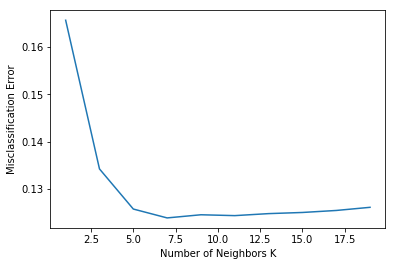

In [44]:
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [45]:
classifier = KNeighborsClassifier(n_neighbors = optimal_k)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [46]:
y_pred = classifier.predict(X_test)

In [48]:
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)
acc

85.017667844522975

In [49]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 192,  972],
       [  88, 5823]], dtype=int64)

# kNN for TF - IDF avg w2v

In [50]:
'''
This function calculates TF - IDF weighted average W2V
It takes in 4 parameters as follows:
       1. list_of_sent - This is the list of sentences/reviews for which sentence vetors are to be constructed
       2. w2v_model - This is the Word2Vec model which is trained on the working corpus - contains the word vectors
       3. tf_idf - This is the TF-IDF model built using the same reviews/sentences - it is the TF-IDF sparse matrix
       4. tfidf_feat - This is the feature vector constructed from the TF-IDF model
       
       Return Value:
       tfidf_sent_vectors - This is a list of sentence/review vectors constructed by using tfidf weighted average on the word vectors
'''
def cal_tfidf_avg_w2v(list_of_sent, w2v_model, tf_idf,tfidf_feat):
    tfidf_sent_vectors = []
    row = 0
    for sent in list_of_sent:
        sent_vec = np.zeros(300)
        weighted_sum = 0
        for word in sent:
            try:
                vec = w2v_model.wv[word]
                tfidf = tf_idf[row, tfidf_feat.index(word)]
                sent_vec += vec*tfidf
                weighted_sum += tfidf
            except:
                pass
        print(row, weighted_sum)
        sent_vec /= weighted_sum
        tfidf_sent_vectors.append(sent_vec)
        row +=1
    return tfidf_sent_vectors

In [52]:
tf_idf_vect = TfidfVectorizer()
tf_idf = tf_idf_vect.fit_transform(final['Summary'].values)
tfidf_feat = tf_idf_vect.get_feature_names()
w2v_model = gensim.models.Word2Vec(list_of_sent, min_count = 5, size = 300, workers = -1)

In [53]:
tfidf_sent_vectors = cal_tfidf_avg_w2v(list_of_sent[:25000], w2v_model, tf_idf, tfidf_feat)  #calling the above function for 60k points. It prints the row and weighted sum just to check the progress.

0 1.17459855914
1 1.0
2 1.98520244693
3 1.32980493239
4 1.47215906958
5 1.0
6 1.40713863086
7 1.0
8 0.789045593653
9 1.29415580187
10 1.0
11 1.41290077598
12 1.22225600963
13 1.21020294211
14 1.31623641879
15 1.97863954301
16 0.422243819628
17 1.0
18 1.73096011775
19 1.7122023812
20 1.39425686989
21 1.0
22 0.515286707522
23 1.2304428259
24 1.40279252972
25 1.35532590084
26 0.924167729306
27 1.0
28 0.8944740503
29 1.19120848427
30 1.0
31 1.20607734958
32 1.1918030313
33 2.2590421372
34 1.03416189684
35 0.667292171521
36 0.584395475237
37 1.74679488624
38 1.15050870575
39 0.449742650073
40 1.07157703905
41 1.97228005249
42 1.40224247656
43 1.64593850538
44 1.07603144073
45 1.3197138993
46 1.87541107059
47 1.0937487419
48 1.56180124482
49 1.13493181623
50 1.32558497604
51 1.23587215701
52 1.36617505495
53 1.93803116221
54 0.605687315335
55 2.92434268448
56 1.32816164647
57 1.39491602572
58 1.77232252251
59 0.900632723495
60 1.13382377963
61 1.94496466991
62 1.98445172834
63 1.40855983426


C:\Users\Pratheesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


 1.0
319 1.0
320 1.4017089662
321 1.0
322 0.901309027371
323 0.663712409329
324 1.88728659714
325 1.69817821829
326 0.503379061359
327 1.65347979982
328 1.38529067799
329 2.24529390809
330 0.451659641707
331 1.797639057
332 1.0
333 0.705495418431
334 0.665988900262
335 1.57985148473
336 0.586473456462
337 0
338 0.742617202458
339 1.7940181994
340 1.59950387531
341 1.9464386987
342 1.0
343 1.94219476342
344 1.41419217789
345 1.72429877652
346 1.39274970044
347 0.712488048949
348 1.41420948159
349 0.779667212231
350 0.933109113229
351 1.0
352 1.0
353 1.81649482288
354 1.49257723345
355 0.742617202458
356 1.64842626399
357 1.12410707396
358 0.489208524629
359 1.41327942429
360 1.14771237191
361 1.44166819468
362 1.41225531265
363 0.714983705642
364 1.58836565604
365 1.0
366 1.31858016557
367 1.34696497833
368 2.13728089516
369 1.90642715745
370 1.0
371 1.25250820814
372 1.56482916102
373 1.22942506455
374 2.59344371601
375 1.48185797091
376 1.37102706103
377 1.38627830602
378 1.0
379 1.32

820 1.65726743659
821 1.81539357589
822 0.665908326403
823 1.09327407727
824 2.23295404817
825 0.920312100789
826 1.0
827 0.857504207834
828 1.0
829 0.371784393795
830 1.63869917188
831 1.414139775
832 1.66138799917
833 1.39933774335
834 1.38042710063
835 1.57462272325
836 1.40846026509
837 1.40855983426
838 1.52822680859
839 1.20529974959
840 1.63280555266
841 1.6914106317
842 1.25266135583
843 0.944714378694
844 1.49586880073
845 0.986301615137
846 3.04579294425
847 1.39530601714
848 0
849 1.27768369122
850 1.41314597062
851 1.38521895313
852 1.0
853 2.0997458157
854 1.27152510594
855 1.57760978353
856 0.964026238896
857 1.72370741971
858 1.26095624973
859 0.75924142232
860 1.40494879809
861 2.34439202749
862 1.39696822808
863 1.16264480827
864 1.31419277389
865 1.39638982986
866 1.0
867 1.66657282468
868 1.0
869 1.0
870 1.2962714847
871 0
872 1.25073286465
873 1.34254596615
874 1.0
875 2.36693069592
876 1.81050946073
877 1.21952346854
878 2.20370325667
879 1.35043551022
880 1.684308

1316 0.755595591834
1317 0.943639756124
1318 1.67572947966
1319 1.63074617273
1320 1.97869807337
1321 1.44121189581
1322 1.0
1323 1.37539684054
1324 1.27485917545
1325 1.68916669286
1326 1.81750301023
1327 1.93372665905
1328 1.38063177643
1329 1.28883753773
1330 1.0574283496
1331 1.35852933247
1332 1.3423610164
1333 1.0
1334 1.0
1335 0.838796981663
1336 1.27233916334
1337 0.956759514408
1338 1.82944638117
1339 1.0
1340 1.0
1341 1.40219161778
1342 2.17715931146
1343 1.3410403126
1344 1.15369910467
1345 1.68615291764
1346 1.0
1347 1.39950085246
1348 1.40286102266
1349 1.3571202991
1350 0.439194340555
1351 1.34900632593
1352 1.5389871924
1353 1.49006699745
1354 1.19168924036
1355 1.7240595806
1356 1.73803527453
1357 0.742617202458
1358 1.12008637631
1359 1.22164014734
1360 1.40097434227
1361 1.23204245484
1362 1.12407278917
1363 1.22952673905
1364 1.63406437146
1365 0.953247296572
1366 1.38279695768
1367 1.38058083214
1368 1.21115771998
1369 1.12242958191
1370 0.886845154986
1371 2.065510

2071 1.3782874312
2072 1.37872250507
2073 1.07434135656
2074 1.3578019534
2075 1.0
2076 2.20671431644
2077 1.5967037741
2078 2.39749262108
2079 1.12565039247
2080 1.99087208306
2081 1.0
2082 0.658624415602
2083 1.32644236953
2084 2.61475780986
2085 1.40760407042
2086 1.06959815073
2087 1.04421682095
2088 1.2020664033
2089 0.742617202458
2090 1.40616474807
2091 1.91597241384
2092 1.75068658866
2093 1.0
2094 1.39491602572
2095 1.69848698895
2096 1.39508288081
2097 0.84735047503
2098 1.29444474873
2099 1.0
2100 1.0
2101 1.29503139369
2102 0.714983705642
2103 1.81171543571
2104 1.71038586085
2105 1.19707479761
2106 1.96080028962
2107 0.886172956327
2108 1.22942506455
2109 1.65749805941
2110 1.0746869227
2111 0.586168593319
2112 1.41419389553
2113 2.60649657398
2114 1.41343999155
2115 1.40616474807
2116 2.02287364139
2117 1.50454354164
2118 1.37945688535
2119 1.84433786066
2120 1.00428915205
2121 1.38567574438
2122 1.40621576858
2123 2.20883453871
2124 1.26105774443
2125 1.72270301245
2126 

2570 1.40673164402
2571 1.99505465747
2572 1.40738208122
2573 1.96153863729
2574 0.897907505172
2575 1.0
2576 1.69435398889
2577 1.33347930108
2578 1.39535144695
2579 0.797041140866
2580 1.11283309767
2581 1.41308199159
2582 0.331705048022
2583 0.608628236559
2584 2.13131911475
2585 1.16132613876
2586 1.15146848368
2587 1.02046242834
2588 0.386783545764
2589 1.16919298542
2590 1.5645016623
2591 0.851334844541
2592 1.63044332895
2593 1.6677993684
2594 1.92786104394
2595 1.7032159545
2596 0.852734697
2597 1.0
2598 1.0
2599 1.93211177365
2600 0.742617202458
2601 1.56460658475
2602 2.85230686999
2603 1.40533220073
2604 0.898850323476
2605 1.70793259066
2606 1.4031645555
2607 0.891804935636
2608 1.39667800459
2609 1.0
2610 1.83360716519
2611 1.35201660452
2612 1.97652255527
2613 1.64872942019
2614 0.913079250666
2615 1.6885892007
2616 1.39572855177
2617 1.7686374283
2618 0.784153676193
2619 0.566249606725
2620 1.0
2621 2.41843854346
2622 1.67544449557
2623 1.33518546715
2624 1.49514827579
2

3072 1.85573107719
3073 1.51128454467
3074 1.65524027606
3075 2.28748107913
3076 1.41420902261
3077 1.23485833192
3078 1.0
3079 1.68071955267
3080 1.0
3081 1.27133470781
3082 1.44219920056
3083 1.39626772408
3084 1.0
3085 0
3086 0.998115375258
3087 2.17530314066
3088 1.4134530133
3089 1.40836916842
3090 1.94498512194
3091 1.37128932908
3092 1.7111172618
3093 0.719498384816
3094 1.83274467908
3095 1.3895828775
3096 0.909587698649
3097 1.23621571554
3098 1.39572855177
3099 2.11630405284
3100 1.29094953643
3101 0.894927400479
3102 1.40697761689
3103 1.04653907551
3104 1.04513235713
3105 1.01526348722
3106 1.75054407606
3107 1.37128932908
3108 0.822724004247
3109 1.7271154452
3110 1.69988856513
3111 1.41419206577
3112 1.70416186843
3113 0.783143447251
3114 1.96902196985
3115 1.32022298591
3116 1.0
3117 1.40224014444
3118 1.38416428732
3119 2.73119620093
3120 1.45636625621
3121 1.07475950508
3122 2.93261644508
3123 0.534522249319
3124 1.69435398889
3125 1.71305585755
3126 1.28887814762
3127

3568 1.42284445149
3569 0.894968176979
3570 1.35751298205
3571 1.88111826084
3572 2.03952486484
3573 1.75411199512
3574 0
3575 0.971696755845
3576 1.47851719382
3577 0.742983169904
3578 1.57322665788
3579 1.39491602572
3580 1.41407742094
3581 1.27546374473
3582 1.31209783646
3583 1.0
3584 1.63465496948
3585 1.40849818119
3586 1.72420518609
3587 1.87061170945
3588 2.36249323788
3589 1.36561310392
3590 2.1445857861
3591 1.02637635186
3592 1.12380006595
3593 1.89014500137
3594 2.01616496626
3595 1.40175439308
3596 1.19168924036
3597 1.77466024459
3598 0.501931130107
3599 1.58837766047
3600 0.836784875463
3601 0.454980108351
3602 2.54744011709
3603 0.263201739977
3604 1.72795967198
3605 1.72008685047
3606 1.93636632981
3607 1.54193260927
3608 1.58489676545
3609 1.68951985599
3610 1.45379059339
3611 1.71925887091
3612 0
3613 2.26627433904
3614 1.13062876286
3615 1.35085319859
3616 1.0
3617 1.9339469991
3618 1.67914602252
3619 1.52173766748
3620 1.60499956411
3621 1.72663024007
3622 0.777747

4066 1.31732432002
4067 1.77649796458
4068 1.55114060463
4069 1.58076679795
4070 1.31684132526
4071 1.0771144442
4072 1.0
4073 1.31772987766
4074 1.18519221479
4075 1.37686470876
4076 1.01945360155
4077 1.84847158931
4078 1.35144398777
4079 1.35099085574
4080 1.27988468183
4081 1.20451634089
4082 1.23959538709
4083 1.64301631069
4084 0.998577616325
4085 1.73718183828
4086 0.536060846958
4087 1.0
4088 2.17264836738
4089 1.51603557813
4090 2.31163557809
4091 1.60938788578
4092 1.80961821997
4093 1.41361182301
4094 1.39491602572
4095 2.13080896501
4096 0.761039419967
4097 1.40624308934
4098 1.36411954735
4099 1.78062780458
4100 1.28012136908
4101 1.35201660452
4102 1.73206455367
4103 1.0
4104 1.38042710063
4105 0.455012147764
4106 1.32280284995
4107 0.76894136796
4108 1.43155594794
4109 0.428158333411
4110 1.36716368366
4111 2.4269930645
4112 1.40670430357
4113 1.80084941002
4114 1.36357034863
4115 1.35313420309
4116 0.947350550789
4117 2.7012319655
4118 1.41381225376
4119 0.742617202458


4566 1.73161226004
4567 1.20779909254
4568 1.55115813488
4569 1.19120848427
4570 1.39665820945
4571 1.13997105932
4572 1.0
4573 1.23752555805
4574 1.2072346649
4575 1.82833472987
4576 1.0
4577 1.98943788282
4578 1.54467653439
4579 1.41182350099
4580 1.23830255198
4581 2.1276504146
4582 1.39102787558
4583 0.611168519931
4584 1.52408636096
4585 1.01954789824
4586 1.30464243843
4587 1.07111768167
4588 1.24201374615
4589 1.25636441131
4590 1.85328174664
4591 2.12581406888
4592 1.70024434288
4593 1.0
4594 0.705495418431
4595 1.08392844926
4596 1.39456496276
4597 1.33488276768
4598 1.21115771998
4599 1.0
4600 2.03323078537
4601 1.41241835114
4602 1.0
4603 1.63476018569
4604 1.32154021925
4605 2.3610381725
4606 1.39185311107
4607 1.11000501719
4608 1.68794462423
4609 1.72799612717
4610 1.33087570502
4611 1.16785180612
4612 1.691258445
4613 0.857272409449
4614 1.0
4615 0.727101801459
4616 1.39724673417
4617 1.0
4618 1.94186935041
4619 1.1511743824
4620 1.36173229876
4621 0.662858067106
4622 1.

5063 1.64905449562
5064 1.27006028119
5065 1.68931511991
5066 1.54358883951
5067 1.41421317554
5068 1.64090156591
5069 0.470709037216
5070 0.910484587479
5071 1.33562199262
5072 1.71192387672
5073 2.39760903011
5074 0.639774318188
5075 0.48627228752
5076 1.23031496137
5077 1.0
5078 1.46332749423
5079 1.40861827631
5080 1.16224911224
5081 1.33973496377
5082 1.2755684356
5083 1.60431011326
5084 1.41288626969
5085 1.17002868641
5086 1.39508288081
5087 1.53329456164
5088 1.41376010985
5089 1.73104720336
5090 0.851115190986
5091 2.24791008062
5092 1.40435382531
5093 2.06215193002
5094 1.40097434227
5095 1.23340121988
5096 1.37128932908
5097 1.30512425565
5098 1.71479307681
5099 1.1852245011
5100 1.9969185337
5101 1.25382127304
5102 0.415739610251
5103 2.49649853069
5104 1.56343529269
5105 1.0
5106 1.29554279694
5107 1.72965226195
5108 1.40581346246
5109 2.11074681032
5110 1.40670430357
5111 1.0
5112 1.0
5113 1.33272275098
5114 2.6205037874
5115 0.76342590322
5116 0.943409381879
5117 1.38717

5564 1.99301867109
5565 1.41396675652
5566 1.0
5567 1.0537607137
5568 1.4017089662
5569 1.0
5570 1.40626335158
5571 0.985131677846
5572 1.72377120576
5573 1.86415477046
5574 1.81426090942
5575 1.34508810125
5576 2.05065874797
5577 1.72271992982
5578 1.80185575333
5579 0.742617202458
5580 1.40291883757
5581 1.75901959493
5582 1.3075838732
5583 1.0
5584 1.41288626969
5585 1.4114251809
5586 1.27914571229
5587 0.586473456462
5588 2.34756216122
5589 1.39491602572
5590 0.820835466808
5591 0.442405484856
5592 1.60827158326
5593 0.939138653771
5594 1.41421343735
5595 1.0
5596 1.89816229927
5597 1.4082258197
5598 1.86813834142
5599 2.45902073809
5600 0.594310355357
5601 1.29175172024
5602 1.41198081347
5603 0.356027692169
5604 1.20834830986
5605 1.72104352297
5606 1.29420613131
5607 0.874204139708
5608 1.0
5609 1.71820512542
5610 1.1619704748
5611 1.0
5612 1.0
5613 1.70968984468
5614 1.17678319798
5615 1.41027980199
5616 1.93920342538
5617 0.966012442948
5618 1.61039031412
5619 2.03212553287
56

6316 0.556351065362
6317 0.0
6318 1.9465291659
6319 0.63974318643
6320 1.0
6321 1.63706606476
6322 1.37412979556
6323 1.97492823888
6324 1.39873323139
6325 0
6326 0.944873805685
6327 1.0
6328 1.94583200721
6329 1.0
6330 2.15641866141
6331 1.40482894829
6332 1.41143083422
6333 1.31098452061
6334 1.3728587202
6335 2.32088331326
6336 1.60497197233
6337 1.51033289643
6338 1.32363589974
6339 1.70243527813
6340 1.3882547225
6341 0.553947809888
6342 1.27280804478
6343 1.51467968073
6344 1.05670956533
6345 1.57891367504
6346 2.42610420787
6347 1.6310655786
6348 1.13759784761
6349 1.0
6350 1.0
6351 0.335162549951
6352 1.55047224107
6353 1.84925173741
6354 1.21093857171
6355 1.0
6356 0
6357 1.08229069119
6358 1.38892271187
6359 2.02131533404
6360 0.714983705642
6361 1.73204388848
6362 2.18972389103
6363 1.0
6364 0
6365 1.3221123527
6366 1.60688874896
6367 1.01018535164
6368 1.30412720388
6369 2.07224040521
6370 0.686131713359
6371 0.840482935637
6372 0.628248092589
6373 1.40952211222
6374 1.4088

6814 1.72475964978
6815 2.32327118939
6816 1.31855804043
6817 1.61936409875
6818 1.16082558497
6819 0.4514843554
6820 1.43201837517
6821 1.41049122018
6822 1.6807407898
6823 1.40623904534
6824 0.681448243021
6825 1.33993669991
6826 1.0
6827 1.30468744126
6828 1.39583128437
6829 1.40303456296
6830 2.34641190947
6831 1.05482002086
6832 0
6833 1.94671903232
6834 1.73093629347
6835 1.50166651163
6836 2.04682494752
6837 2.6013643051
6838 0.765183839186
6839 1.4407735111
6840 1.29001131527
6841 1.362885801
6842 1.63036306798
6843 2.03078137054
6844 1.41334458747
6845 1.15296223296
6846 1.58585753419
6847 1.0
6848 1.27777090443
6849 1.15680457631
6850 1.3882547225
6851 1.86157419164
6852 1.35086313454
6853 1.82105615581
6854 1.20329807801
6855 0.461970977579
6856 1.39572855177
6857 1.38892271187
6858 2.20785919213
6859 1.68071955267
6860 1.19261709968
6861 2.29170703956
6862 1.53463985494
6863 1.61982792918
6864 1.6589777808
6865 1.40885614845
6866 1.6217786387
6867 1.0
6868 1.39572855177
686

7308 0
7309 1.0
7310 2.40730628626
7311 1.37441316012
7312 2.17872128763
7313 1.95633727526
7314 1.93667620105
7315 1.41288626969
7316 1.99555998943
7317 2.19341732119
7318 1.9145977869
7319 2.56735228637
7320 1.39558264239
7321 1.41297024417
7322 1.0
7323 1.0
7324 0.9132338016
7325 3.20571839591
7326 1.82731570389
7327 1.53618479822
7328 0.5029207101
7329 1.22324969347
7330 1.65852367144
7331 0.392781579218
7332 2.15025562635
7333 1.49510955445
7334 1.18236082983
7335 1.28084700658
7336 1.4112997091
7337 1.11519174936
7338 2.1389604358
7339 0
7340 1.37008435162
7341 1.0
7342 1.88672022973
7343 1.17878137744
7344 0.87773952316
7345 0.663143397176
7346 1.23134820301
7347 1.62840522265
7348 1.95643821537
7349 0.801349543225
7350 1.37406171207
7351 1.59717214768
7352 1.64578677455
7353 1.36289470107
7354 1.40097434227
7355 1.65857493139
7356 1.0524363658
7357 1.39875624718
7358 1.49503982276
7359 1.85317893777
7360 1.41242239416
7361 1.96617063064
7362 1.51416499171
7363 1.25231100231
736

8065 1.71767121615
8066 0.714983705642
8067 1.96072887619
8068 1.0
8069 2.63371778237
8070 1.0
8071 1.0
8072 1.50135331529
8073 1.30806172264
8074 1.79768020671
8075 1.0
8076 1.88152370275
8077 1.95159012624
8078 1.58978900396
8079 0.714983705642
8080 0.734471222519
8081 1.67619531952
8082 1.0
8083 1.26869843126
8084 1.0
8085 1.68261184019
8086 1.96238930483
8087 1.01472142245
8088 1.68476802648
8089 1.0
8090 0.365729786523
8091 0.681448243021
8092 1.38126953552
8093 1.69687809225
8094 2.11443817277
8095 0.828482523431
8096 0.701610525672
8097 1.35054354637
8098 1.24457298857
8099 1.40627616378
8100 1.41288626969
8101 1.44357497994
8102 1.08268017184
8103 0.43209376855
8104 1.29371531074
8105 1.38892271187
8106 1.69669233366
8107 1.34375141135
8108 1.0
8109 0.671549766264
8110 1.08579859698
8111 0.663396948802
8112 1.9016890107
8113 1.18427993944
8114 1.72524851351
8115 1.7088705101
8116 1.34508810125
8117 0.875999840749
8118 2.41076413128
8119 0.970080278622
8120 1.33474699138
8121 1.

8565 1.06174892222
8566 1.1090511894
8567 1.38216977235
8568 0.897207623535
8569 1.49583700903
8570 1.96932272468
8571 1.35467947525
8572 0.519298818615
8573 1.93726983955
8574 0.993365982709
8575 1.4136409334
8576 1.6342023164
8577 0.63974318643
8578 0.406950035484
8579 1.19838679351
8580 1.58914098304
8581 1.77148794177
8582 2.14619926055
8583 0.983675101124
8584 2.2395953211
8585 1.40849606141
8586 1.41039350568
8587 1.69670346069
8588 1.13482915731
8589 1.32540148166
8590 1.71190467147
8591 1.67694382701
8592 1.26795433841
8593 1.91160265324
8594 1.0
8595 1.375530861
8596 1.69640741325
8597 0.851115190986
8598 1.61710715383
8599 0.714983705642
8600 1.04481243406
8601 2.1801441459
8602 0.811041198625
8603 1.05174852123
8604 1.34134115442
8605 1.52577552644
8606 1.75218954607
8607 1.0
8608 1.66705614329
8609 1.99683091732
8610 1.31723228495
8611 1.31959101408
8612 1.0
8613 1.73025090507
8614 1.89618450589
8615 1.91392151067
8616 1.40294846016
8617 1.39600591582
8618 1.28747302321
861

9061 1.69824087298
9062 1.0
9063 0.651599499785
9064 1.37499505688
9065 1.72188158282
9066 1.12519350775
9067 1.46576966266
9068 1.48415962959
9069 1.0
9070 1.11661397212
9071 1.0
9072 1.08669863617
9073 1.40085626917
9074 1.72480527681
9075 1.33576763114
9076 1.0
9077 1.49974205655
9078 1.02108024636
9079 0.779667212231
9080 1.362885801
9081 1.94331109739
9082 1.12060962674
9083 1.87737322552
9084 0.433586986585
9085 1.37558557295
9086 0.549552717633
9087 1.33083023396
9088 2.78306880216
9089 0.88422719295
9090 1.0929449373
9091 1.25849960732
9092 2.26101925469
9093 1.39192935657
9094 1.24492903999
9095 0.386783545764
9096 1.65834234763
9097 2.26948026953
9098 1.53315147277
9099 1.0
9100 1.63803097981
9101 1.0
9102 0.775371602376
9103 1.0
9104 1.21093857171
9105 1.23372063087
9106 1.05415230535
9107 1.34933873651
9108 1.48973558939
9109 0.512940809646
9110 0.584969767993
9111 1.25214960917
9112 1.6151120094
9113 0.405436026158
9114 0.791488250407
9115 1.38795804294
9116 3.81374981019


9566 1.23060376557
9567 0.954685709341
9568 1.41403625932
9569 1.0
9570 1.15363650667
9571 0.746173376231
9572 1.0
9573 1.36945178001
9574 1.85105207816
9575 0
9576 1.31619406362
9577 1.46498067509
9578 2.31717612543
9579 1.36205231507
9580 0.825262575129
9581 1.39121665209
9582 1.35031782891
9583 0
9584 1.4017382646
9585 1.82473754416
9586 1.67329241885
9587 1.39540058631
9588 1.70056198862
9589 1.0
9590 1.54027964447
9591 1.30238564139
9592 1.10546623798
9593 1.40842138485
9594 1.0
9595 1.26223853275
9596 1.33152442756
9597 0.825262575129
9598 0.917731922376
9599 1.4468689977
9600 1.29394357152
9601 0.939697439388
9602 0.849781623656
9603 1.34508810125
9604 0.839705082297
9605 1.21101484458
9606 1.0
9607 1.74546324357
9608 1.82279568532
9609 1.39989662022
9610 0.769102808696
9611 1.69792603955
9612 1.81852508867
9613 0.758200599775
9614 1.60142480646
9615 1.37128932908
9616 1.59978417134
9617 1.80248620859
9618 2.05783585567
9619 1.0
9620 1.68209657823
9621 1.93765204698
9622 1.0
962

10065 0.96938599682
10066 0.452950927489
10067 0.635893929334
10068 1.64525363335
10069 1.37673637194
10070 1.31951454705
10071 1.0
10072 0.775664287087
10073 1.06817489555
10074 0.976077827299
10075 0.714983705642
10076 2.40711456325
10077 1.41110262684
10078 1.34725556557
10079 1.39025349075
10080 0
10081 1.0
10082 0.349356167771
10083 1.90832850622
10084 1.60833198726
10085 1.72253717165
10086 1.16704918477
10087 1.41421270265
10088 1.0
10089 1.26029189057
10090 1.0
10091 1.39491602572
10092 1.4130582079
10093 2.03527336637
10094 1.3950000734
10095 1.11474272349
10096 1.67703135967
10097 1.28256314247
10098 1.20018513189
10099 3.14972398773
10100 0.757052326225
10101 0.521059071528
10102 2.08417891805
10103 0.733210455264
10104 1.71752923171
10105 1.90900963781
10106 2.13962765779
10107 0.75122732423
10108 2.13470838367
10109 1.72225782056
10110 1.0
10111 1.08829770752
10112 1.94765845302
10113 0.714983705642
10114 1.39491602572
10115 0
10116 2.24548763363
10117 1.24220798534
10118 

10564 1.3010143383
10565 1.0
10566 1.0
10567 1.61890847082
10568 1.38042710063
10569 1.03452644148
10570 1.96982574796
10571 1.41414412623
10572 1.89204196685
10573 1.69697572649
10574 1.85152205836
10575 2.3254505674
10576 1.71684821652
10577 1.41286647997
10578 1.13452039143
10579 0.544976643947
10580 1.98381042568
10581 1.03024730344
10582 1.54486901465
10583 1.31855804043
10584 1.35620125311
10585 1.41360266726
10586 1.4234531247
10587 1.37691133391
10588 1.56653698303
10589 1.67062069221
10590 1.74004534926
10591 1.21093857171
10592 0
10593 2.06877245783
10594 0.621925218724
10595 1.8050995707
10596 2.4927148257
10597 0
10598 1.0
10599 1.41414015568
10600 1.61807412736
10601 1.37838725859
10602 1.06480361946
10603 1.46173224397
10604 1.15996161382
10605 1.12650639865
10606 0.714983705642
10607 2.16060034576
10608 1.0
10609 1.08783561587
10610 1.40368640367
10611 1.39508288081
10612 1.19996454752
10613 1.85405473552
10614 1.54694694969
10615 1.0
10616 1.39491602572
10617 0.66965561

11062 1.98418048399
11063 1.4658736161
11064 1.21687267997
11065 1.16322256448
11066 1.07925172163
11067 1.39491602572
11068 1.59592709124
11069 1.0148179993
11070 1.41357959307
11071 1.65940041009
11072 1.40205059034
11073 1.0
11074 1.70746099324
11075 3.07523653766
11076 1.79844673623
11077 1.76455398652
11078 1.21783278765
11079 1.34665105478
11080 0.78286034865
11081 1.96389398802
11082 1.88938180301
11083 1.98897481251
11084 1.09460527725
11085 1.28232024461
11086 0.753029467652
11087 1.0
11088 1.0
11089 0.714983705642
11090 0.52611664133
11091 1.0
11092 0.496757925952
11093 0.293970788806
11094 0.987389859478
11095 1.95570024174
11096 0.738895233809
11097 1.92235077382
11098 1.90056265726
11099 1.0
11100 1.6706437047
11101 1.22292941543
11102 1.86339078268
11103 0.700986358897
11104 1.33576763114
11105 0.60516476798
11106 2.34641378666
11107 1.4085341638
11108 1.58690391395
11109 1.0
11110 1.25073286465
11111 1.57066119204
11112 1.0
11113 0
11114 1.66298707409
11115 1.8759134483


11815 1.41242353656
11816 1.40240660984
11817 1.99806397243
11818 1.0
11819 1.0
11820 1.40616474807
11821 0.987139512651
11822 1.44091367887
11823 1.3888748963
11824 0.568820829219
11825 2.09239894885
11826 1.33293320984
11827 2.03676889871
11828 1.60927758224
11829 1.35656072566
11830 1.6014745448
11831 1.98861773946
11832 1.41032602237
11833 1.3582407146
11834 1.06058416709
11835 2.52189558492
11836 1.44915936436
11837 0.853466012935
11838 0.48270128071
11839 1.95981481788
11840 2.10555497546
11841 1.8210126647
11842 1.35201660452
11843 1.74932934161
11844 1.61490457929
11845 0.973289527045
11846 1.86621146879
11847 1.36502641048
11848 2.1417038108
11849 1.21729503094
11850 0.98436416161
11851 1.21142431379
11852 1.00201247562
11853 1.68749037167
11854 1.7801175543
11855 2.10593522886
11856 1.38717803943
11857 0.584969767993
11858 1.18600255557
11859 1.2356859706
11860 1.03264127389
11861 0.60516476798
11862 1.52760308476
11863 0.924831128775
11864 2.07203821915
11865 2.58745365345
1

12315 1.43214127065
12316 2.36995077472
12317 1.65219831791
12318 0.96160064393
12319 1.0
12320 1.0
12321 1.37236625926
12322 1.3882547225
12323 1.0
12324 1.16224911224
12325 2.2754645596
12326 1.41550646988
12327 1.66324226473
12328 1.86236691232
12329 1.497640265
12330 2.0394109582
12331 1.31990909023
12332 1.65534034887
12333 1.69990254876
12334 1.46517446294
12335 1.41402001471
12336 0.455546634082
12337 1.0
12338 0.742617202458
12339 1.71472150595
12340 1.0
12341 1.6540393044
12342 1.74588302449
12343 1.16857401632
12344 0.0
12345 1.18695971632
12346 1.41333204348
12347 2.14167050809
12348 0.803342722111
12349 1.41376882194
12350 1.96329786961
12351 0.33445755959
12352 2.76076253373
12353 1.39007457642
12354 1.88124906214
12355 1.0
12356 2.12582239425
12357 1.16189648726
12358 1.2200569259
12359 0.949174747466
12360 1.3882547225
12361 1.97986121591
12362 1.86449089786
12363 1.06981622514
12364 1.64292460504
12365 1.26348536899
12366 1.0
12367 1.68446468931
12368 0.803376439901
123

12807 1.0
12808 1.0
12809 3.01481264326
12810 1.39491602572
12811 1.41310087933
12812 0.692460910265
12813 1.547619498
12814 1.56358744309
12815 2.1304547539
12816 1.41061816414
12817 1.96221586136
12818 1.40807359253
12819 1.97104119591
12820 1.0990817921
12821 1.0
12822 1.41066555629
12823 2.07963018551
12824 2.04085009878
12825 1.0
12826 2.24395774844
12827 1.01432917118
12828 1.49617201537
12829 1.76399784206
12830 1.60431036327
12831 1.86142600782
12832 0.679325494961
12833 1.85825669644
12834 1.19853717371
12835 2.1399413967
12836 1.68613805989
12837 1.71465265203
12838 1.0
12839 1.4050398944
12840 1.37319938771
12841 1.66818098589
12842 1.64838622261
12843 1.7452281521
12844 1.52030935802
12845 1.0
12846 1.3958266869
12847 1.60451220208
12848 1.91826797009
12849 2.0792519203
12850 1.85642587937
12851 1.0
12852 1.0
12853 1.0
12854 1.39310366955
12855 0.586473456462
12856 1.0
12857 0.943513933672
12858 1.94375144516
12859 1.70669313479
12860 1.0
12861 0.671071410572
12862 1.351521

13566 2.17242272421
13567 1.4844023132
13568 1.29791031133
13569 1.40482894829
13570 0.950262218646
13571 1.99263577626
13572 1.70534528387
13573 1.91389044859
13574 1.30798330254
13575 1.21115771998
13576 1.0
13577 1.48593541105
13578 0.719498384816
13579 1.45010293429
13580 1.10078495248
13581 1.23983749934
13582 1.15682917385
13583 1.0
13584 4.07555434503
13585 1.08204969818
13586 1.41388605606
13587 1.24240361865
13588 1.77734569096
13589 1.32816164647
13590 2.11074604312
13591 1.17426199722
13592 1.43949292889
13593 1.45018368806
13594 1.54656664113
13595 1.19728818017
13596 1.95001599114
13597 1.06752580697
13598 1.38399594252
13599 0.476384091015
13600 1.49898984699
13601 1.70584010759
13602 1.38423753912
13603 1.74401804701
13604 1.47995935034
13605 1.15636943665
13606 1.21122164534
13607 1.0
13608 1.36734397747
13609 0.579222396561
13610 1.0
13611 1.26000609487
13612 1.34234954575
13613 1.32726269798
13614 1.82005092489
13615 1.41363919119
13616 0.714983705642
13617 1.63302815

14060 1.71275322823
14061 1.27886028599
14062 1.45662910471
14063 0.457306095202
14064 1.0
14065 1.1309640183
14066 1.19120848427
14067 1.81712961568
14068 1.57649228049
14069 1.63192166496
14070 1.69797590075
14071 1.66454547371
14072 1.0
14073 1.22363526537
14074 1.33229479614
14075 2.00409251425
14076 2.14952602535
14077 1.38532986029
14078 1.33254634561
14079 2.36006410953
14080 1.57215708899
14081 1.2892879693
14082 1.71558474211
14083 1.1978703303
14084 1.0
14085 0.875915949695
14086 0.609918637553
14087 1.39587900804
14088 1.14458291745
14089 1.41018051892
14090 1.71501775147
14091 1.96368241415
14092 1.06333547937
14093 2.6249713251
14094 1.41135284568
14095 0.967761576516
14096 1.41243391224
14097 1.50729594911
14098 1.61229036744
14099 1.95427032042
14100 0.742617202458
14101 1.56854203878
14102 1.67165761167
14103 1.80394255988
14104 1.24549644651
14105 1.0729807672
14106 1.40415320023
14107 1.32411606737
14108 1.63197759692
14109 2.22315065402
14110 0
14111 0.870646121252
1

14554 1.38042710063
14555 1.82220460449
14556 0.875466923196
14557 1.40986099564
14558 1.92900246717
14559 1.98913029075
14560 1.66411826666
14561 0.386783545764
14562 1.56668497612
14563 1.39491602572
14564 1.49224628453
14565 1.29691611838
14566 1.36154201879
14567 0.63974318643
14568 1.45331668254
14569 1.67168920063
14570 2.62905636828
14571 0.92546037812
14572 1.65171816239
14573 1.76228783914
14574 1.25269153195
14575 1.02488018663
14576 1.41289645654
14577 1.61982574158
14578 1.77030358433
14579 1.59971261975
14580 1.41055093336
14581 1.18230594495
14582 1.46178037699
14583 1.39491602572
14584 1.07204387107
14585 0.933755834923
14586 1.0
14587 1.65321148835
14588 1.40979109372
14589 2.16264245355
14590 0.633185026409
14591 1.6111366962
14592 0
14593 2.17196728995
14594 0
14595 1.26243446039
14596 1.35201660452
14597 2.11316638593
14598 1.24257796951
14599 0.671893930342
14600 1.414177494
14601 1.41216255987
14602 1.73628783193
14603 1.50092063958
14604 1.61283740126
14605 1.5818

15314 1.55074337412
15315 0.971696755845
15316 1.04846551412
15317 2.12659484398
15318 1.38160256913
15319 1.16964937928
15320 1.63210005734
15321 1.27544721674
15322 1.40556754722
15323 1.96551320281
15324 0.448466126548
15325 0.891168566191
15326 1.41055551128
15327 2.00577264048
15328 2.15781068987
15329 1.32034758454
15330 1.72444927762
15331 1.32552566057
15332 1.26858143671
15333 1.51437761764
15334 1.63824201858
15335 1.31765870604
15336 1.42135473308
15337 1.72344897385
15338 1.0
15339 1.0
15340 1.67631536412
15341 1.50345132556
15342 0.549285897566
15343 1.37342461785
15344 1.23247675112
15345 1.60509236073
15346 2.03323078537
15347 2.51601439133
15348 1.41376255706
15349 1.19711643579
15350 1.79309105388
15351 0.983780582181
15352 1.53242162669
15353 2.00262999956
15354 2.37299892194
15355 1.58212398833
15356 2.11952288225
15357 0.948901825093
15358 0.971988899537
15359 1.41394375287
15360 1.58310523298
15361 1.6652117708
15362 1.88154837398
15363 1.0
15364 1.31850809529
1536

15812 1.66786521805
15813 1.2568592746
15814 1.36308610446
15815 1.41399854967
15816 0.655009111656
15817 1.0
15818 1.38094541652
15819 1.96682225894
15820 1.94662181512
15821 1.28520291282
15822 1.21735430792
15823 1.56266940049
15824 1.0
15825 1.54156578136
15826 1.60526395759
15827 1.85915590631
15828 1.89011528163
15829 1.19120848427
15830 2.39800708083
15831 1.19865751946
15832 2.14567334994
15833 0.244030397327
15834 2.32446885466
15835 1.34595472436
15836 1.24847072872
15837 1.0
15838 1.18596335645
15839 1.0
15840 0.777747705097
15841 1.30227723162
15842 1.41418963123
15843 1.71315927213
15844 1.0
15845 1.86931562133
15846 0.610854551878
15847 1.33973673407
15848 1.29961628046
15849 1.2143828576
15850 1.32047065443
15851 1.87858450263
15852 1.95210874241
15853 1.96197108599
15854 1.67451011068
15855 1.97360863521
15856 1.66514800828
15857 2.57734889739
15858 1.9917420915
15859 1.7038120086
15860 1.92528872597
15861 1.39508288081
15862 1.67639017456
15863 1.41236048575
15864 1.06

16313 1.35451595439
16314 0.742617202458
16315 1.41120435193
16316 1.55723337177
16317 1.25578966192
16318 0.810868320293
16319 0.163279702119
16320 1.37316060404
16321 1.503214042
16322 1.0
16323 0.574290863016
16324 1.0
16325 1.60851956934
16326 1.0
16327 1.90132470179
16328 1.0
16329 0.939446848702
16330 1.26207845582
16331 1.64742979957
16332 0.974928562344
16333 2.20883311249
16334 1.30188726264
16335 1.91332782112
16336 1.21687206512
16337 1.33576763114
16338 1.47728536015
16339 2.09317713011
16340 2.39757726055
16341 0.810074039605
16342 1.75868523922
16343 1.35957924157
16344 1.32085242261
16345 1.04592429151
16346 1.18204034374
16347 1.39491602572
16348 1.23080892216
16349 1.53867366854
16350 1.5603612868
16351 1.0
16352 1.51811449379
16353 1.08968889844
16354 1.1441014641
16355 1.27822949247
16356 0.611761366431
16357 1.13389631207
16358 0.906802998687
16359 1.95602499078
16360 2.16593154301
16361 2.397898303
16362 1.01063538748
16363 2.23468574748
16364 1.44903483393
16365 1

16813 1.01195316728
16814 1.0
16815 2.00290631301
16816 1.70481713228
16817 2.60317793325
16818 1.14039319837
16819 1.48362219817
16820 0.824428717569
16821 1.23033052397
16822 1.33036274017
16823 1.21273454759
16824 1.7285562542
16825 0.540683285598
16826 0.446892056835
16827 1.96444544111
16828 1.0
16829 1.95486265017
16830 1.59560838964
16831 1.0
16832 1.17187667525
16833 1.35744301077
16834 1.47123598573
16835 1.88305274315
16836 0
16837 1.47762958167
16838 2.04062505415
16839 1.39292778763
16840 1.85041400489
16841 1.77942579117
16842 2.01041843561
16843 0.940376306372
16844 1.31916723011
16845 1.0
16846 1.3379257315
16847 1.66296143643
16848 1.18358884566
16849 1.37497704999
16850 2.27736937127
16851 1.77976871894
16852 1.87205410672
16853 0.890025535689
16854 1.72326336747
16855 2.21226243542
16856 1.9777399892
16857 1.36359279684
16858 1.2915547433
16859 1.23036732154
16860 1.40719680857
16861 1.0
16862 1.02848818208
16863 1.0
16864 1.72951221775
16865 0
16866 1.67579974214
168

17311 0.826080848379
17312 1.38892271187
17313 1.39226045375
17314 1.82585079316
17315 0.773106567081
17316 1.22332648863
17317 1.41404850231
17318 1.87016392588
17319 0.584969767993
17320 0
17321 0
17322 1.0
17323 1.85965801428
17324 1.41283953925
17325 1.0
17326 1.1119528671
17327 1.46092438222
17328 1.15432312913
17329 1.78512936876
17330 1.59860282761
17331 1.41413813367
17332 1.79921767518
17333 0.899030517016
17334 1.97239456973
17335 1.57428343144
17336 1.40347440187
17337 1.39274970044
17338 1.89699880328
17339 0.965300567063
17340 0.732661562658
17341 1.73186663518
17342 1.38278412957
17343 1.03612157022
17344 0.546446583835
17345 1.95826104655
17346 1.3340829159
17347 2.31378382367
17348 1.87074048335
17349 1.70894464059
17350 1.39544907902
17351 1.41329336637
17352 1.79590659731
17353 0.878059139849
17354 1.13980048152
17355 1.4308112245
17356 1.97365987771
17357 1.30771779466
17358 1.41336503269
17359 1.0
17360 1.0
17361 0.714983705642
17362 0.733429766886
17363 1.969594731

17811 2.1052801353
17812 1.0
17813 2.3013094447
17814 0
17815 1.40616474807
17816 0.855883540602
17817 1.46139111219
17818 1.1982541311
17819 1.35716539235
17820 1.1619704748
17821 1.22015029219
17822 0.628140655287
17823 1.54657022493
17824 0
17825 1.41685356181
17826 1.07576851227
17827 1.7040310914
17828 1.41244032845
17829 1.70795468497
17830 1.55411534758
17831 1.66042387533
17832 1.33646103512
17833 1.34414636869
17834 0.835950514628
17835 1.0
17836 1.18659486372
17837 1.18259615535
17838 1.68231575256
17839 1.48936561869
17840 0.833037732284
17841 1.71997288298
17842 0
17843 1.30442079405
17844 1.0
17845 1.39167128823
17846 1.0
17847 2.15681430352
17848 1.45259138901
17849 0.453173833969
17850 1.73369178133
17851 1.08800033946
17852 1.2684997246
17853 1.81341683015
17854 2.18732437878
17855 1.0
17856 1.3798587195
17857 1.0
17858 1.67067119168
17859 1.32591553529
17860 1.41108237553
17861 1.87491448213
17862 2.14611006779
17863 0.352729150051
17864 1.82416932342
17865 0.900276092

18312 1.98048078065
18313 1.36508217932
18314 1.1963717212
18315 1.40355419886
18316 1.18567410012
18317 1.0
18318 1.6777150526
18319 1.67551978938
18320 0.534108647965
18321 2.07157238495
18322 1.0
18323 1.53833773515
18324 1.10335182901
18325 1.51869234324
18326 1.362885801
18327 1.40778909029
18328 1.37090359552
18329 1.38785798233
18330 1.57162287462
18331 1.64106832521
18332 1.57100586539
18333 0.884577615034
18334 1.41310087933
18335 1.45661573878
18336 1.35461437695
18337 1.68340946662
18338 1.68125057147
18339 1.69972532699
18340 1.89150235248
18341 1.0
18342 2.08118048832
18343 1.32373320405
18344 0.219740275458
18345 1.41316609994
18346 1.22466590791
18347 2.25136444735
18348 1.63870365256
18349 1.68481871244
18350 1.39572855177
18351 1.90954851285
18352 1.0
18353 1.0
18354 1.27545326362
18355 1.39508288081
18356 1.23115776043
18357 2.1864761735
18358 0.742617202458
18359 1.76435054122
18360 1.841640731
18361 1.62780888142
18362 1.67977721936
18363 1.48773781751
18364 1.75202

18808 1.56498359539
18809 0.945721303345
18810 0.779667212231
18811 1.49693671621
18812 0.649236064515
18813 1.64817708639
18814 0.729407238776
18815 1.41105459121
18816 1.60411298996
18817 1.12671420686
18818 1.46984318115
18819 1.08082214301
18820 1.27362648941
18821 0.489134038218
18822 1.48032430798
18823 1.29186093322
18824 1.29196405755
18825 1.33935444787
18826 1.38846611904
18827 1.81224651939
18828 0.99133050742
18829 0.791744015441
18830 1.5028095037
18831 1.78594630135
18832 1.24328363437
18833 0.489447393656
18834 1.04796277776
18835 1.62188168187
18836 1.39484092984
18837 1.19616528198
18838 2.01256893683
18839 0
18840 0.402590504092
18841 1.40325641333
18842 0
18843 1.57958285588
18844 0.616810588605
18845 1.77046051243
18846 0.579111802036
18847 1.41005050541
18848 1.170732653
18849 2.32226085556
18850 1.0
18851 0.936469255099
18852 1.4821320385
18853 1.20143906848
18854 0.85055118081
18855 0.998387145146
18856 0.608628236559
18857 1.98603382941
18858 0.798273248041
1885

19310 2.21613498005
19311 0.564153183458
19312 1.71315927213
19313 1.01048337781
19314 1.40771017923
19315 1.0
19316 1.0
19317 1.65352803102
19318 1.3639771661
19319 1.41349959869
19320 1.08268017184
19321 1.88554699384
19322 2.06214650733
19323 1.27424188907
19324 1.66540898511
19325 1.92338226633
19326 1.41394240483
19327 1.77584728492
19328 1.08413085177
19329 1.0
19330 2.17425659696
19331 0
19332 2.37101336598
19333 1.0
19334 1.47014054162
19335 1.14320477644
19336 1.41157729637
19337 1.41005050541
19338 1.27989573633
19339 1.39517702213
19340 1.19180578239
19341 1.72003842101
19342 1.64516515059
19343 1.39929672481
19344 1.84719390868
19345 2.52900354703
19346 1.21540879266
19347 1.0
19348 1.0
19349 2.1187136144
19350 1.4110434755
19351 1.21092257737
19352 1.33576763114
19353 1.85773976037
19354 1.92966081149
19355 1.9948826783
19356 1.32020301306
19357 0.942691056247
19358 0.956829378669
19359 1.18461984681
19360 0.470522496967
19361 1.80505046335
19362 1.0
19363 1.21607764288
19

19812 1.30718762857
19813 2.66643435925
19814 1.4138074884
19815 2.01738796661
19816 2.70030492454
19817 1.3102311451
19818 1.93750355202
19819 1.4440765832
19820 0.554851927806
19821 1.67642714889
19822 1.32894607207
19823 1.40990155402
19824 1.0
19825 1.76921703654
19826 1.93558660255
19827 0.744670484519
19828 1.64264105521
19829 1.68821502773
19830 1.16224911224
19831 1.60179758659
19832 1.0
19833 1.53275454398
19834 0.60516476798
19835 1.7036975936
19836 1.39717048754
19837 1.72278475673
19838 1.31863689786
19839 1.67054225153
19840 2.50939369136
19841 1.9398867825
19842 1.0
19843 2.07908684482
19844 1.69064365982
19845 1.0
19846 1.04592429151
19847 1.62811913981
19848 1.39508288081
19849 3.12622147649
19850 1.34172732861
19851 0.828119059262
19852 2.03587512436
19853 2.42333609667
19854 1.0
19855 0.780936732219
19856 1.6651901383
19857 1.31505204718
19858 0.391266147216
19859 2.50060194647
19860 2.03474695587
19861 1.0
19862 1.83117349319
19863 1.67246706016
19864 1.51579515346
1

20309 2.39789702695
20310 1.2405357557
20311 1.49278516219
20312 1.11402616282
20313 1.16671213856
20314 1.26154533975
20315 1.22348403542
20316 1.72671034622
20317 1.97866589574
20318 1.0
20319 1.90463463278
20320 0.60516476798
20321 1.30679465608
20322 2.22953363939
20323 1.71366746697
20324 0.715517737129
20325 1.0
20326 1.33701439999
20327 0.345937037659
20328 1.5195076119
20329 1.18248741808
20330 1.3541868649
20331 1.38247193791
20332 1.95459025155
20333 1.41407368588
20334 1.1817159274
20335 1.2441668754
20336 2.01194771558
20337 2.35692632685
20338 1.0
20339 1.3574266278
20340 0.829110420731
20341 1.15820316469
20342 1.60648656285
20343 1.80415297915
20344 0.293600544333
20345 1.48215435657
20346 1.65242515961
20347 1.67102107201
20348 1.19805729284
20349 1.66537756096
20350 1.54532921931
20351 1.61961385143
20352 1.0
20353 1.69585597471
20354 0
20355 1.08248485053
20356 2.59429469021
20357 1.85750353511
20358 1.76092641033
20359 0.542287083123
20360 1.88839466606
20361 1.24773

20813 1.0
20814 1.78903848643
20815 1.0
20816 1.0
20817 1.17312728926
20818 1.72715573314
20819 1.2842589326
20820 1.07881301025
20821 1.34512442251
20822 1.72386444163
20823 1.0
20824 1.84942457957
20825 1.31971226463
20826 1.16743616961
20827 1.90991125046
20828 1.78961956856
20829 1.26133349999
20830 1.39491602572
20831 1.85131579207
20832 1.32262635832
20833 1.65494720419
20834 1.0
20835 1.9956941817
20836 1.69346556487
20837 1.33993669991
20838 0.741070226177
20839 1.1502184265
20840 1.0
20841 0
20842 1.58096884265
20843 1.47107892977
20844 1.35532590084
20845 2.09362862126
20846 1.14323071462
20847 1.08204969818
20848 1.0
20849 1.41234437881
20850 0.761082495067
20851 1.47970977631
20852 1.97883130711
20853 1.87406462779
20854 1.0
20855 1.41301515457
20856 1.0
20857 2.42333609667
20858 1.43587999246
20859 1.72770154064
20860 1.40713247891
20861 1.21098851118
20862 1.71272821784
20863 1.2229558648
20864 1.12867070087
20865 1.22842445539
20866 1.35655867464
20867 1.0
20868 1.706741

21311 1.58780240193
21312 1.35201660452
21313 1.57724662712
21314 1.97656266746
21315 1.40567219492
21316 1.66439241593
21317 1.39995154606
21318 1.42568806013
21319 1.10421056613
21320 1.0
21321 1.08424692289
21322 0.852936247051
21323 1.30373383672
21324 1.89852490299
21325 1.63975693558
21326 1.69927460875
21327 1.35623362019
21328 1.30806172264
21329 0.488740837349
21330 1.72193870681
21331 0.584969767993
21332 1.58577072656
21333 1.4601601885
21334 1.34711727559
21335 1.07195024295
21336 1.01814060439
21337 1.39917183365
21338 1.0
21339 1.95449396077
21340 1.38345794575
21341 1.76311358092
21342 1.68350007254
21343 0.525091455512
21344 1.94359607056
21345 1.71078633002
21346 1.79457489697
21347 1.28415563562
21348 1.40347440187
21349 1.0
21350 1.63990959135
21351 1.35857889528
21352 1.22967601645
21353 0.915516906241
21354 1.31732432002
21355 1.40894532885
21356 1.94533865998
21357 2.0960926484
21358 1.0
21359 1.2741004225
21360 1.52358037527
21361 0.770624194886
21362 1.004869655

21810 0.0
21811 1.0
21812 1.98712018079
21813 1.27966811786
21814 1.69273951432
21815 1.0
21816 1.0
21817 1.41288626969
21818 2.05168654076
21819 1.35713577059
21820 1.27442967388
21821 1.70104191654
21822 1.41306755886
21823 3.0
21824 1.40097434227
21825 0.825883625002
21826 1.89910514293
21827 1.0
21828 1.40347440187
21829 1.5440806126
21830 1.39491602572
21831 1.31235701462
21832 1.0
21833 1.0
21834 1.2746336692
21835 0.797815707299
21836 1.28474449996
21837 1.0
21838 2.32298895275
21839 0.934286288915
21840 1.0
21841 0.451615703767
21842 0.615989263032
21843 0.682061988868
21844 1.41380892629
21845 1.71819582771
21846 0.742617202458
21847 1.0
21848 1.94804244757
21849 1.54385233801
21850 1.71041386387
21851 1.58257854865
21852 2.13371073867
21853 1.41286518486
21854 1.40521687731
21855 2.18360356752
21856 1.99385648178
21857 1.38160256913
21858 0.940454156467
21859 1.59106585436
21860 0.742617202458
21861 1.0
21862 1.8155479655
21863 1.83149046698
21864 1.50872671459
21865 1.395728

22308 1.7709276274
22309 1.38262956603
22310 0.556028511869
22311 1.59167051843
22312 1.4110434755
22313 1.28040935111
22314 2.36160407822
22315 1.41408376222
22316 1.8895394995
22317 1.97098492645
22318 1.0
22319 1.0
22320 1.65746975123
22321 1.40473627914
22322 2.23278020492
22323 1.56698790918
22324 1.41160645812
22325 0.795005432858
22326 1.79134860315
22327 1.41301994547
22328 1.63111056097
22329 1.40917533054
22330 1.54909076792
22331 0
22332 1.92628196652
22333 0.965308335163
22334 0.856200150105
22335 1.41376882194
22336 2.24963348595
22337 1.66076867549
22338 1.75997171267
22339 1.14334894275
22340 1.84414078877
22341 2.29567132156
22342 1.29032518051
22343 1.71896520749
22344 1.5730819735
22345 1.12654334492
22346 1.91948162586
22347 1.35148197311
22348 1.41414899182
22349 0
22350 1.56736282795
22351 1.93693063869
22352 1.31006664308
22353 1.56743155415
22354 1.0
22355 1.23051489224
22356 0.766718757036
22357 0.428158333411
22358 1.80933851629
22359 1.67003127165
22360 1.1858

22808 1.8935534444
22809 1.0
22810 0.742617202458
22811 0.974346722053
22812 1.0
22813 1.0
22814 1.92851072217
22815 0.845497531271
22816 1.23416971476
22817 0.860101686901
22818 1.3916210096
22819 1.84717927962
22820 1.30759578605
22821 1.72018274964
22822 1.85541080441
22823 1.99798142553
22824 1.29809235215
22825 0
22826 1.84986881263
22827 1.74317982585
22828 1.3486579883
22829 1.90114688167
22830 0.777747705097
22831 1.33049855413
22832 2.10213429406
22833 2.30858267104
22834 1.0
22835 1.0
22836 0.836469320013
22837 1.0
22838 1.32991563199
22839 1.66574194369
22840 0.214031824409
22841 1.57466059704
22842 0.63974318643
22843 1.39556532968
22844 1.06168853297
22845 2.01718538213
22846 1.45189934663
22847 1.67146667589
22848 1.23967632522
22849 2.54684921292
22850 2.29887741865
22851 1.72804005313
22852 1.72817251234
22853 1.0
22854 1.71106393526
22855 2.34320896994
22856 2.0
22857 1.2531111101
22858 1.39491602572
22859 1.39572855177
22860 1.0
22861 1.94887334578
22862 0.61334501922

23307 1.33488420862
23308 1.61713065668
23309 1.728649182
23310 1.58486262693
23311 1.02133855258
23312 1.07576851227
23313 1.22095308559
23314 1.41349906811
23315 2.29864911328
23316 1.0
23317 1.4016665272
23318 0.633084600179
23319 1.41163517104
23320 1.70545324312
23321 1.37593996661
23322 1.85430146114
23323 1.40176513924
23324 1.68333868895
23325 2.403437389
23326 1.0
23327 2.14495111693
23328 0.753032886237
23329 1.0
23330 1.0
23331 1.69093113154
23332 1.0
23333 1.78911968866
23334 1.0
23335 1.36391462308
23336 1.3904208338
23337 1.72620515258
23338 0.524265104085
23339 1.41365952711
23340 1.19168924036
23341 1.7125329548
23342 1.85524971825
23343 1.0
23344 1.98112767935
23345 1.66347031925
23346 1.39585879343
23347 0.680269180745
23348 1.55220044686
23349 0.336449035255
23350 1.64198801139
23351 1.55061145304
23352 1.9384446046
23353 1.29454221989
23354 0.855263388759
23355 1.2175994554
23356 1.40493547909
23357 1.64408838151
23358 1.0
23359 2.01674521182
23360 1.38801094946
233

23811 1.28006770644
23812 1.2298039698
23813 1.68951985599
23814 0.743734955425
23815 1.30902896838
23816 0.482435785066
23817 1.23958466525
23818 1.0
23819 1.4514514536
23820 1.2814784018
23821 1.72274421457
23822 1.0
23823 1.49428988331
23824 1.40413004725
23825 1.71609669357
23826 1.47473322335
23827 0.746585661513
23828 0.714983705642
23829 0.714983705642
23830 0.853190992425
23831 1.74023608583
23832 1.75515977597
23833 1.50551929065
23834 1.39572855177
23835 0.926634527622
23836 0.457452542702
23837 1.28579896807
23838 1.52891596923
23839 1.0
23840 1.56063556228
23841 1.63484760548
23842 1.33034266371
23843 1.55285442916
23844 1.0
23845 1.19197375589
23846 1.97599895404
23847 0.941015265626
23848 1.1732142033
23849 0.518512291764
23850 1.45505473771
23851 0.998928717414
23852 1.35819141383
23853 1.74571701061
23854 0.713013900574
23855 1.51854225336
23856 0.715517737129
23857 2.21686426549
23858 1.27609873722
23859 1.71127521568
23860 3.25716171133
23861 0.50302451623
23862 1.032

24306 1.63098291911
24307 1.8755834994
24308 1.64265574507
24309 1.39491602572
24310 0.595684237594
24311 2.15518640696
24312 1.4002060525
24313 1.0
24314 1.17389065071
24315 1.0
24316 1.89082496013
24317 0.813522239081
24318 0.906070635044
24319 1.40731524719
24320 0.933191726323
24321 1.0133381519
24322 1.63949144663
24323 1.18767721342
24324 1.39976021511
24325 1.29987799223
24326 0.503607579135
24327 1.71895509925
24328 1.1619704748
24329 1.27774426306
24330 1.3581362856
24331 0.973100244264
24332 0.979385478176
24333 1.47472909756
24334 0.549285897566
24335 1.2568592746
24336 1.0
24337 1.72843810832
24338 1.541714708
24339 0.319665249277
24340 0.437197093249
24341 1.35728246273
24342 1.23794128323
24343 1.61424224015
24344 0.714983705642
24345 1.39491602572
24346 0.611367493759
24347 0.484391137467
24348 2.00608888894
24349 0.732661562658
24350 0.633150256801
24351 1.56825858469
24352 0.231515004849
24353 1.82648622074
24354 1.3871883553
24355 1.51314215044
24356 2.57517809158
243

In [54]:
with open('tfidf_sent_vectors_summary.pkl','wb') as pickle_file:  #Saving as pickle file
    pickle.dump(sent_vectors,pickle_file)

In [4]:
with open('tfidf_sent_vectors_summary.pkl','rb') as pickle_file:  #Loading the pickle file for future use
    sent_vectors_summary = pickle.load(pickle_file)

In [5]:
with open('tfidf_sent_vectors.pkl','rb') as pickle_file:  #Loading the pickle file saved earlier
    tfidf_sent_vectors = pickle.load(pickle_file)

In [6]:
data1 = np.array(tfidf_sent_vectors)

In [7]:
data2 = np.array(sent_vectors_summary)

In [8]:
data = np.concatenate((data1,data2), axis = 1)

In [9]:
data.shape

(364171, 600)

In [10]:
df = pd.DataFrame(data)

In [11]:
df['Time'] = final['Time'].iloc[:25000]  #Taking corresponding 25k timestamps

In [12]:
df['Score'] = final['Score'].iloc[:25000] #Taking corresponding Scores

In [15]:
df.shape

(364171, 602)

In [16]:
df = df.dropna(axis = 0)
df.shape

(23583, 602)

In [17]:
df = df.sort_values('Time')  #sorting on time
df

,0,1,2,3,4,5,6,7,8,9,...,592,593,594,595,596,597,598,599,Time,Score
17261,-0.061172,-0.064371,0.159644,0.341457,0.586426,0.007634,0.256289,-0.034597,-0.511193,0.161363,...,-0.189128,0.176310,-0.008952,0.082845,0.049886,-0.067383,0.045817,0.053223,9.486720e+08,1.0
8335,0.438500,-0.349241,0.016273,-0.013079,0.953234,0.060930,0.215382,0.563688,0.275181,-0.079543,...,-0.122070,0.221680,0.083984,0.013123,0.002655,-0.025879,0.084473,0.010925,9.599904e+08,1.0
624,0.465237,-0.367616,0.071377,0.301178,0.351475,0.060850,-0.181773,-0.325573,-0.114658,0.231218,...,-0.258789,0.015259,-0.102798,0.034180,0.094727,-0.014160,0.004395,-0.070868,9.617184e+08,1.0
8649,0.214202,0.021747,0.168707,-0.012720,0.808202,-0.509290,0.085827,0.041970,-0.008234,0.041029,...,-0.185384,0.036336,0.021729,-0.072184,-0.159749,0.056625,0.011637,-0.020142,1.015718e+09,1.0
9248,0.152204,-0.040646,0.165063,0.034092,0.125451,-0.299073,0.120723,0.219277,-0.293808,-0.531996,...,-0.145508,0.055298,-0.136230,0.089966,0.150879,0.041168,0.119629,-0.048584,1.029197e+09,1.0
8794,-0.031110,-0.236836,-0.176793,0.063441,0.772066,-0.355367,-0.101804,0.442083,0.002540,0.259296,...,-0.060059,0.162354,-0.055420,-0.103149,0.022949,-0.045410,0.163086,0.016602,1.069805e+09,1.0
18095,0.498177,-0.342867,-0.252315,0.598225,0.902704,-0.668341,0.190181,0.408102,-0.100895,-0.047865,...,-0.218750,0.211914,0.111735,-0.140218,-0.144857,-0.042480,0.057617,-0.053101,1.071187e+09,1.0
12348,0.214650,0.246076,0.484059,-0.173584,0.382179,0.276877,-0.100525,-0.084479,0.020626,0.110458,...,0.012451,0.100708,0.301758,-0.324219,0.121094,-0.070190,-0.056473,0.117432,1.071878e+09,1.0
20214,0.051516,0.175933,-0.257945,0.237305,-0.016382,0.129445,0.215985,-0.211226,-0.170669,0.183930,...,-0.080566,-0.106079,-0.075317,-0.104980,0.084717,-0.019043,-0.045837,0.105469,1.072138e+09,1.0
23585,0.206818,-0.195566,0.247836,0.268418,0.104745,-0.455513,0.262174,0.054583,-0.042494,-0.060062,...,-0.079102,0.231445,0.091309,-0.060791,-0.036621,-0.222656,0.144531,0.126953,1.073347e+09,1.0


In [20]:
X = df.iloc[:,:600].values #Creating a numpy array of vectors
print(X[:5,:])
X.shape

[[-0.06117153 -0.06437081  0.15964408 ..., -0.06738281  0.04581706
   0.05322266]
 [ 0.43849954 -0.3492413   0.01627256 ..., -0.02587891  0.08447266
   0.01092529]
 [ 0.46523693 -0.36761567  0.07137724 ..., -0.01416016  0.00439453
  -0.07086754]
 [ 0.21420216  0.02174695  0.16870685 ...,  0.05662537  0.01163737
  -0.0201416 ]
 [ 0.1522041  -0.04064595  0.16506267 ...,  0.04116821  0.11962891
  -0.04858398]]


(23583, 600)

In [23]:
y = df['Score'].values  #Creating a numpy array of Scores
print(y[:5]) 
type(y)

[ 1.  1.  1.  1.  1.]


numpy.ndarray

In [24]:
s = StandardScaler()  #Performing Column Standardization
X = s.fit_transform(X)
X[:5,:]

array([[-0.32775354,  0.1536939 , -0.36833728, ..., -0.23573663,
         0.31026841,  0.40805705],
       [ 1.05940474, -0.73484488, -0.76949729, ...,  0.11064624,
         0.69878203, -0.00993455],
       [ 1.13363157, -0.79215634, -0.61531188, ...,  0.20844846,
        -0.10605461, -0.81822882],
       [ 0.43672317,  0.42230355, -0.34297922, ...,  0.79920952,
        -0.03325943, -0.31694425],
       [ 0.26460771,  0.22769404, -0.3531758 , ...,  0.67020737,
         1.05212495, -0.59801797]])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) #splitting data

In [26]:
#5 fold CV
neighbors = list(range(1,20,2))
cv_scores = []

for k in neighbors:
    print(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())
    
MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

1
3
5
7
9
11
13
15
17
19

The optimal number of neighbors is 7.


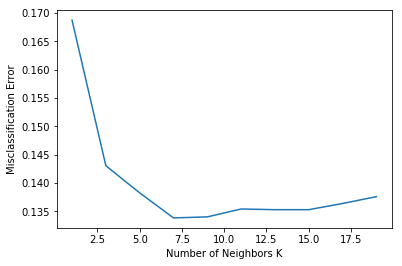

In [27]:
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [28]:
classifier = KNeighborsClassifier(n_neighbors = optimal_k)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [29]:
y_pred = classifier.predict(X_test)

In [30]:
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)  #calculating accuracy
acc

87.250883392226157

In [31]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 170,  813],
       [  89, 6003]], dtype=int64)